In [44]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master spark://iahlvldpt002.logistics.corp:7077 --packages com.datastax.spark:spark-cassandra-connector_2.12:3.0.0  pyspark-shell'

from pyspark import SparkContext
from pyspark.conf import SparkConf

from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import desc, max,count, avg

spark = SparkSession.builder \
    .appName('SparkCassandraApp_GroupBy_test1') \
    .config('spark.cassandra.connection.host', 'avengers-cassandra.kac.logistics.corp') \
    .config('spark.cassandra.connection.port', '9042') \
    .config('spark.cassandra.auth.username','mlai') \
    .config('spark.cassandra.auth.password','mlai') \
    .config('spark.cassandra.output.consistency.level','ONE') \
    .config('spark.cassandra.connection.timeoutBeforeCloseMS','12000000') \
    .config('spark.cassandra.read.timeoutMS','12000000') \
    .config('spark.cassandra.connection.timeoutMS','12000000') \
    .config('spark.cores.max','3') \
    .config('spark.sql.catalog.myCatalog','com.datastax.spark.connector.datasource.CassandraCatalog') \
    .master('spark://iahlvldpt002.logistics.corp:7077') \
    .getOrCreate()


sqlContext = SQLContext(spark)
df = sqlContext \
  .read \
  .format('org.apache.spark.sql.cassandra') \
  .options(table='stop_feature_label', keyspace='ml_ai_forecast_model') \
  .load()
#df.show(50000)

df.groupBy('route_start_year').count().sort(desc("count")).show(1000)  

#df.filter(df.trip_id=='128843365').show()

#df.groupBy('trip_id').count().withColumnRenamed("count", "n").filter("n > 2").sort(desc("n")).show()
#.filter("'count' > 2").sort(desc("'count'"))




+----------------+-------+
|route_start_year|  count|
+----------------+-------+
|            2017|2600854|
|            2018|2547195|
|            2020|2401430|
|            2019|2315474|
|            2021| 657605|
+----------------+-------+



In [5]:
df.show(10)

+-------------+---------+------------------+------------------+----------------+-------------+-------------------+------+------------------+------------------+-------------------+------------------+----------+-----------------------------------+-----------------+-------------------------------------+-----------+-------------+----------+------------+----------------+----------------+-------------------+-----+--------------------+--------+---------+-----------------+--------------------+---------+
|partition_key|  stop_id|actual_distance_mi|arrive_status_type|business_unit_id|         city|    conveyance_type|county|depart_status_type|       entity_type|     event_datetime|event_layover_mins|event_type|event_variance_sched_vs_actual_mins|        lane_name|layover_variance_sched_vs_actual_mins|postal_code|priority_type|route_name|route_name_1|route_start_date|route_start_year|         route_type|state|           stop_name|stop_nbr|stop_role|svc_provider_code|     trans_mode_type|  trip_id

In [51]:
from pyspark.sql.window import Window  
from pyspark.sql import Row, functions as F
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

df.select(col("trip_id"),col("stop_id"),col("conveyance_type"),col("city"),col("state"),col("depart_status_type"),col("entity_type"),col("priority_type"),col("route_name"),col("route_start_year"), col("route_type"),  col("stop_name"), col("stop_nbr"), col("stop_role"), col("svc_provider_code"), \
F.row_number().over( Window.partitionBy("trip_id","stop_role").orderBy("stop_nbr")).alias("od_stop_num") ).sort(col("trip_id"), col("stop_role"), col("od_stop_num")).show(1000)

+---------+---------+--------------------+-----------------+---------+------------------+--------------------+-------------+---------------+----------------+-------------------+--------------------+--------+---------+-----------------+-----------+
|  trip_id|  stop_id|     conveyance_type|             city|    state|depart_status_type|         entity_type|priority_type|     route_name|route_start_year|         route_type|           stop_name|stop_nbr|stop_role|svc_provider_code|od_stop_num|
+---------+---------+--------------------+-----------------+---------+------------------+--------------------+-------------+---------------+----------------+-------------------+--------------------+--------+---------+-----------------+-----------+
|102951903|374062682| 53' Trailer (53ST*)|           GRAHAM|       NC|          Inactive|               Plant|      Unknown|         HPE614|            2017|Less Than Truckload|HPE Consolidation...|       2|        D|             CUOT|          1|
|1029519

In [2]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+----------------+--------------------+---------------+--------+------------------+-----------+------------------+----------+-----------------------------------+-----------------+-------------------------------------+-----------------+-------------+-------------+-------------+----------------+------------------+----------+------------------+---------+------------------+---------+-----------------+---------------+--------------------+
|summary|       partition_key|             stop_id|  actual_distance_mi|arrive_status_type|business_unit_id|                city|conveyance_type|  county|depart_status_type|entity_type|event_layover_mins|event_type|event_variance_sched_vs_actual_mins|        lane_name|layover_variance_sched_vs_actual_mins|      postal_code|priority_type|   route_name| route_name_1|route_start_date|  route_start_year|route_type|             state|stop_name|          stop_nbr|stop_role|

<AxesSubplot:xlabel='partition_key'>

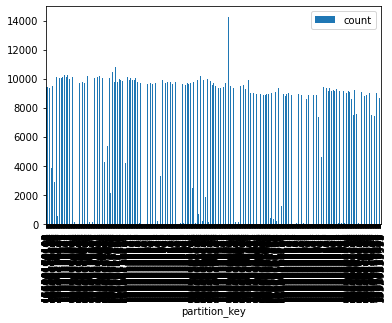

In [37]:
import matplotlib.pyplot as plt
#df.groupBy('partition_key').count().show() 
rpdf=df.groupBy('partition_key').count().sort(('partition_key')).toPandas()

rpdf.plot(x ='partition_key', y='count', kind = 'bar')  

<AxesSubplot:xlabel='partition_key'>

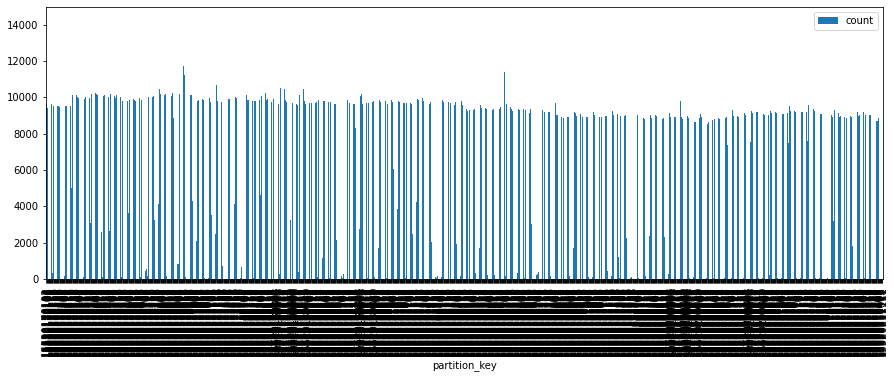

In [43]:
rpdf.plot(x ='partition_key', y='count', kind = 'bar', figsize=(15,5))  

                 entity_type    count
0                   Supplier  5004159
1                      Plant  4309499
2                  Crossdock   708630
3         Warehouse Facility   188853
4            Border Crossing   105954
5                  Rail Yard    83096
6                      Other    53025
7   Deconsolidation Facility    16716
8            Transfer Center    13278
9                       Yard    11892
10                     Depot    11038
11                   Airport     7538
12                Sub-Consol     5736
13                      Port     1662
14           Remote Domicile      718
15                  Customer      485
16              Dealer/Store      154
17              Sub-Assembly       76
18             Road Terminal       35
19           Carrier Address        6
20                   Station        4
21           Customer Branch        2
22          Personal Address        2


<AxesSubplot:xlabel='entity_type'>

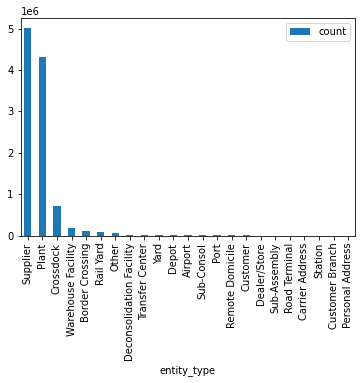

In [7]:
#svc_provider_code
pdf=df.groupBy('entity_type').count().sort(desc("count")).toPandas()
print(pdf)
import matplotlib.pyplot as plt
pdf.plot(x ='entity_type', y='count', kind = 'bar')

  arrive_status_type    count
0            Pending  3390447
1            On Time  2844033
2              Ahead  1891505
3           Inactive  1284018
4               Late   954604
5        Late Report   156328
6          No Status     1623


<AxesSubplot:title={'center':'arrive_status_type'}, ylabel='count'>

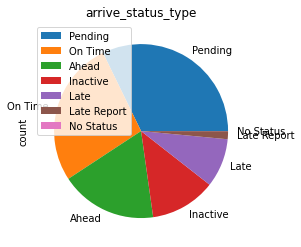

In [13]:
posdf=df.groupBy('arrive_status_type').count().sort(desc("count")).toPandas()
print(posdf)
posdf.plot.pie(title="arrive_status_type",labels=posdf.arrive_status_type,y='count')

In [39]:
from pyspark.sql.functions import col,when,count

linedf=df.groupBy('route_start_year')  \
         .agg( count(  when(col("entity_type")=='Supplier', True)).alias("Supplier")         \
                ,count(  when(col("entity_type")=='Plant', True)).alias("Plant")          )  \
         .sort(("route_start_year")).toPandas()

print(linedf)

#         .count().sort(desc("route_start_year")).toPandas()
#linedf.plot.line(x='route_start_year', y='count')

   route_start_year  Supplier    Plant
0              2017   1229881  1073642
1              2018   1189018  1048982
2              2019   1100830   947109
3              2020   1164298   973500
4              2021    320132   266266


<AxesSubplot:xlabel='route_start_year'>

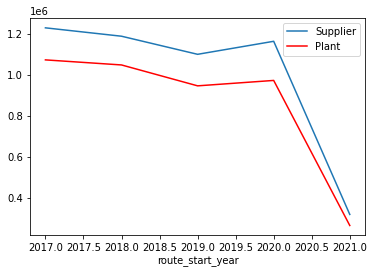

In [41]:
ax = plt.gca()

linedf.plot(kind='line',x='route_start_year',y='Supplier',ax=ax)
linedf.plot(kind='line',x='route_start_year',y='Plant', color='red',ax=ax)